In [1]:
import sys
import gc

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K

print(tf.config.list_physical_devices('GPU'))

sys.path.append('../')
import DCTR

from energyflow.utils import to_categorical
from sklearn.model_selection import train_test_split



2024-08-30 08:33:45.061777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-30 08:33:45.079549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-30 08:33:45.079781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from importlib import reload
reload(DCTR)


# load data

In [2]:
# directory with pre converted lhe files as numpy arrays
data_dir = '../../Data' # modify as needed


In [3]:
# Load POWHEG hvq x0 datasets
# x0_nrm for training, x0_plt and x0_plt_nrm for calculating stats used to decide which model performs best
# only contain tt-pair; every event has order: 
    # tt-pair, top, anti-top
# every particle has arguments: 
    # [pt, y, phi, mass, eta, E, PID, w, theta]
    # [0 , 1, 2  , 3   , 4  , 5, 6  , 7, 8    ]

# POWHEG hvq
x0_nrm = []
x0_nrm = np.load(f'{data_dir}/POWHEG_hvq/showered/normed_lhe_01.npy')[:9543943] # 9543943 num of NNLO samples
print(f'POWHEG hvq x0_nrm.shape:     {x0_nrm.shape}')

# plotting data; different from training data; for calculating stats
x0_plt = []
x0_plt = np.load(f'{data_dir}/POWHEG_hvq/showered/converted_lhe_02.npy')[:9543943]
print(f'POWHEG hvq x0_plt.shape:     {x0_plt.shape}')

x0_plt_nrm = []
x0_plt_nrm = np.load(f'{data_dir}/POWHEG_hvq/showered/normed_lhe_02.npy')[:9543943]
print(f'POWHEG hvq x0_plt_nrm.shape: {x0_plt_nrm.shape}')



POWHEG hvq x0_nrm.shape:     (9543943, 3, 9)
POWHEG hvq x0_plt.shape:     (9543943, 3, 9)
POWHEG hvq x0_plt_nrm.shape: (9543943, 3, 9)


In [4]:
# MiNNLO x1
# training data
x1_nrm = []
x1_nrm = np.load(f'{data_dir}/MiNNLO/showered/normed_lhe.npy')
print(f'MiNNLO all particles x1_nrm.shape: {x1_nrm.shape}')

# plotting data, same as above (due to lack of statistics) but unnormalized
x1_plt = []
x1_plt = np.load(f'{data_dir}/MiNNLO/showered/converted_lhe.npy')
print(f'MiNNLO all particles x1_plt.shape: {x1_plt.shape}')


MiNNLO all particles x1_nrm.shape: (9543943, 3, 9)
MiNNLO all particles x1_plt.shape: (9543943, 3, 9)


In [5]:
# get event generator weights

x0_plt_wgt = x0_plt[:, 0, 7].copy() 

x1_plt_wgt = x1_plt[:, 0, 7].copy()


### prep data

In [6]:
# delete eta (pseudorapidity) and Energy -> Train only with [pt, y, phi, m, PID]

# delete energy
x0_nrm = np.delete(x0_nrm, 5, -1)
x0_plt_nrm = np.delete(x0_plt_nrm, 5, -1)
x1_nrm = np.delete(x1_nrm, 5, -1)

# delete eta
x0_nrm = np.delete(x0_nrm, 4, -1)
x0_plt_nrm = np.delete(x0_plt_nrm, 4, -1)
x1_nrm = np.delete(x1_nrm, 4, -1)


In [7]:
K.clear_session() 
print(gc.collect()) # cpu gabage collection to free up memory from discarded temp arrays


55


# Neural Positive Reweighter

### reweighting NNLO with pos and neg wgt to all pos wgts


In [ ]:
''' TRAINING CODE

# neural positive training:
# compare MSE vs CCE neural positive training
# repeat each training 5 times to get a mean and std for each method and batch size
# try batch sizes of: [4, 8, 16, 32, 64]*8192 for MSE and CCE => 5*5*2=50 trainings
# -> split to run parallel on NAF
# first 25 with MSE, last 25 with CCE

# process_id between 1 and 50

runs = 5
batch_sizes = [4, 8, 16, 32, 64] # mulipliers of 8192

total_runs = 2 * runs * len(batch_sizes) # *2 b/c testing mse and cce

run = (process_id % runs) # process_id starts at 1
if run == 0:
    run = runs # last run would be zero with modulo

loss = ''
if process_id <= int(0.5*total_runs):
    loss = 'mse'
else:
    loss = 'cce'

# want the first num runs to use batch_sizes[0], next num runs batch_sizes[1], etc.
# split process_id into two sets of size int(0.5*total_runs), one for each loss
if process_id <= int(0.5*total_runs):
    p_id = process_id # 1-15 for MSE
else:
    p_id = process_id - int(0.5*total_runs) # 1-15 for CCE

batch_id = int((p_id-1)/runs)
batch_size = 8192*batch_sizes[batch_id]


'''

In [8]:
# data info
save_path='./saved_models/'

runs = 5
batch_sizes = [4, 8, 16, 32, 64] # mulipliers of 8192
losses = ['mse', 'cce']


In [20]:
# calculate rwgt from trained models
# rwgt from X1 with uniform wgts to X1 with pos/neg wgts

'''
for loss in losses:
    for batch_mult in batch_sizes:
        batch_size = batch_mult*8192
        for run in range(1, runs+1):
            print(f'starting with run {run} from {batch_mult = } with {loss} loss')
            # clear previous from mem
            rwgt = []
            predicts = []
            K.clear_session()
            gc.collect()
            
            # identifying string
            save_label = f'DCTR_NNLO_{loss}_pos_rwgt_{run}_batchsize_{batch_size}'

            # load weights
            pos_rwgt = tf.keras.models.load_model(f'{save_path}{save_label}.tf')

            # predict weights
            predicts = pos_rwgt.predict(x1_nrm[...,:-2], batch_size=batch_size) # last two are wgt and theta classifier

            rwgt = predicts[:,1] / predicts[:,0]
            rwgt = np.array(rwgt)
            print(f'mean rwgt: {np.mean(rwgt):.4f}')
            np.save(f'{save_path}{save_label}_X1_rwgt.npy', rwgt)
'''


starting with run 1 from batch_mult = 4 with mse loss


2024-08-29 21:01:30.629597: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 21:01:30.632357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-29 21:01:30.632606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-29 21:01:30.632801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

mean rwgt: 0.8006
starting with run 2 from batch_mult = 4 with mse loss
mean rwgt: 0.8059
starting with run 3 from batch_mult = 4 with mse loss
mean rwgt: 0.7981
starting with run 4 from batch_mult = 4 with mse loss
mean rwgt: 0.8073
starting with run 5 from batch_mult = 4 with mse loss
mean rwgt: 0.8058
starting with run 1 from batch_mult = 8 with mse loss
mean rwgt: 0.8070
starting with run 2 from batch_mult = 8 with mse loss
mean rwgt: 0.8043
starting with run 3 from batch_mult = 8 with mse loss
mean rwgt: 0.8047
starting with run 4 from batch_mult = 8 with mse loss
mean rwgt: 0.8110
starting with run 5 from batch_mult = 8 with mse loss
mean rwgt: 0.8108
starting with run 1 from batch_mult = 16 with mse loss
mean rwgt: 0.8023
starting with run 2 from batch_mult = 16 with mse loss
mean rwgt: 0.8072
starting with run 3 from batch_mult = 16 with mse loss
mean rwgt: 0.8030
starting with run 4 from batch_mult = 16 with mse loss
mean rwgt: 0.8026
starting with run 5 from batch_mult = 16 w

In [9]:
# load wgts from disk and calc histograms for pT, eta and delta_phi
# compare batch sizes and loss functions

# binning for hists
div = 22 # all hists should have same num bins, to avoid nested arrays
pt_bins  = np.logspace(np.log10(10), np.log10(1000), div)
eta_bins = np.linspace(-6, 6, div)
phi_bins = np.linspace(0, np.pi, div)


# calculate delta phi
x1_delta_phi = DCTR.delta_phi(x1_plt)
'''

batch_hists = []
pt_hist = []
eta_hist = []
phi_hist = []
rwgt = []

for loss in losses:
    for batch_mult in batch_sizes:
        batch_size = batch_mult*8192
        batch_hists = []
        for run in range(1, runs+1):
            print(f'starting with run {run} from {batch_mult = } with {loss} loss')
            save_label = f'DCTR_NNLO_{loss}_pos_rwgt_{run}_batchsize_{batch_size}'
            rwgt = np.load(f'{save_path}{save_label}_X1_rwgt.npy')
            # every particle has arguments: 
            # [pt, y, phi, mass, eta, E, PID, w, theta]
            # [0 , 1, 2  , 3   , 4  , 5, 6  , 7, 8    ]
            
            pt_hist  = np.histogram(x1_plt[:,0,0], weights = rwgt, density=True, bins=pt_bins)[0]
            eta_hist = np.histogram(x1_plt[:,0,4], weights = rwgt, density=True, bins=eta_bins)[0]
            phi_hist = np.histogram(x1_delta_phi,  weights = rwgt, density=True, bins=phi_bins)[0]

            batch_hists.append(
                [pt_hist, eta_hist, phi_hist]
            )

        # get mean for each hist bin across runs
        pt_hist_mean  = np.mean(np.array(batch_hists)[:, 0, :], axis=0)
        eta_hist_mean = np.mean(np.array(batch_hists)[:, 1, :], axis=0)
        phi_hist_mean = np.mean(np.array(batch_hists)[:, 2, :], axis=0)
        
        # append mean hists to list of hists of that batch size
        batch_hists.append(
            [pt_hist_mean, eta_hist_mean, phi_hist_mean]
        )

        # get std of hists
        pt_hist_std  = np.std(np.array(batch_hists)[:, 0, :], axis=0)
        eta_hist_std = np.std(np.array(batch_hists)[:, 1, :], axis=0)
        phi_hist_std = np.std(np.array(batch_hists)[:, 2, :], axis=0)
        
        # append std hists to list of hists of that batch size
        batch_hists.append(
            [pt_hist_std, eta_hist_std, phi_hist_std]
        )
        
        batch_hists = np.array(batch_hists)
        
        label = f'DCTR_NNLO_{loss}_pos_rwgt_batchsize_{batch_size}_hists'
        np.save(f'{save_path}{label}.npy', batch_hists)
'''


"\n\nbatch_hists = []\npt_hist = []\neta_hist = []\nphi_hist = []\nrwgt = []\n\nfor loss in losses:\n    for batch_mult in batch_sizes:\n        batch_size = batch_mult*8192\n        batch_hists = []\n        for run in range(1, runs+1):\n            print(f'starting with run {run} from {batch_mult = } with {loss} loss')\n            save_label = f'DCTR_NNLO_{loss}_pos_rwgt_{run}_batchsize_{batch_size}'\n            rwgt = np.load(f'{save_path}{save_label}_X1_rwgt.npy')\n            # every particle has arguments: \n            # [pt, y, phi, mass, eta, E, PID, w, theta]\n            # [0 , 1, 2  , 3   , 4  , 5, 6  , 7, 8    ]\n            \n            pt_hist  = np.histogram(x1_plt[:,0,0], weights = rwgt, density=True, bins=pt_bins)[0]\n            eta_hist = np.histogram(x1_plt[:,0,4], weights = rwgt, density=True, bins=eta_bins)[0]\n            phi_hist = np.histogram(x1_delta_phi,  weights = rwgt, density=True, bins=phi_bins)[0]\n\n            batch_hists.append(\n                

In [10]:
pt_hist_base  = np.histogram(x1_plt[:,0,0], density=True, bins=pt_bins)[0]
eta_hist_base = np.histogram(x1_plt[:,0,4], density=True, bins=eta_bins)[0]
phi_hist_base = np.histogram(x1_delta_phi, density=True, bins=phi_bins)[0]

pt_hist_target  = np.histogram(x1_plt[:,0,0], weights = x1_plt_wgt, density=True, bins=pt_bins)[0]
eta_hist_target = np.histogram(x1_plt[:,0,4], weights = x1_plt_wgt, density=True, bins=eta_bins)[0]
phi_hist_target = np.histogram(x1_delta_phi,  weights = x1_plt_wgt, density=True, bins=phi_bins)[0]


In [11]:
def reduced_chi2_test(hist, target_hist, bins, N):
    bin_widths = []
    for i, _ in enumerate(bins[:-1]):
        width = bins[i+1] - bins[i]
        bin_widths.append(width)
    prob = np.multiply(hist, bin_widths)
    target_prob = np.multiply(target_hist, bin_widths)

    chi2 = np.sum(
            N*np.divide(
                np.power(prob - target_prob, 2),
                target_prob
            )
        )
    reduced_chi2 = chi2/len(bins[:-1])

    return reduced_chi2


starting with batch_mult = 4 and mse loss
(7, 3, 21)


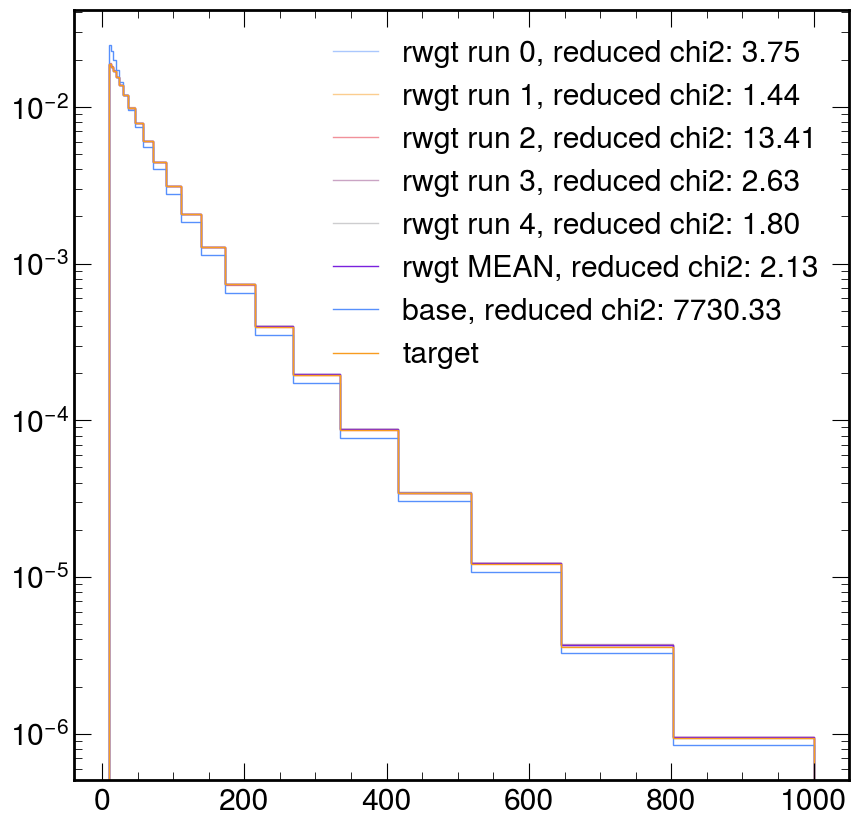

starting with batch_mult = 8 and mse loss
(7, 3, 21)


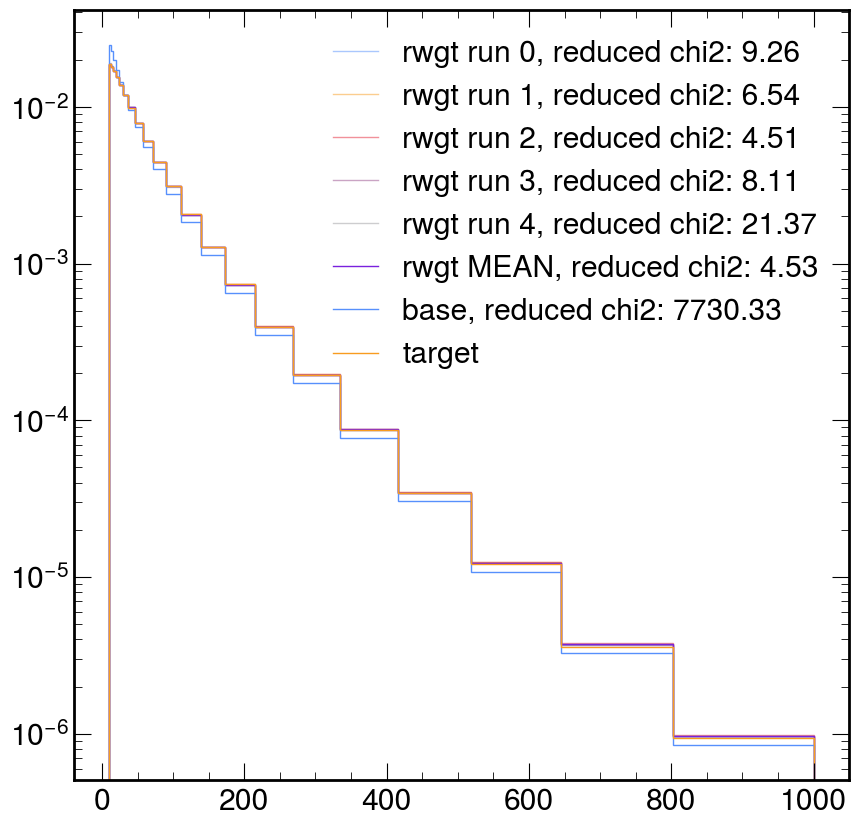

starting with batch_mult = 16 and mse loss
(7, 3, 21)


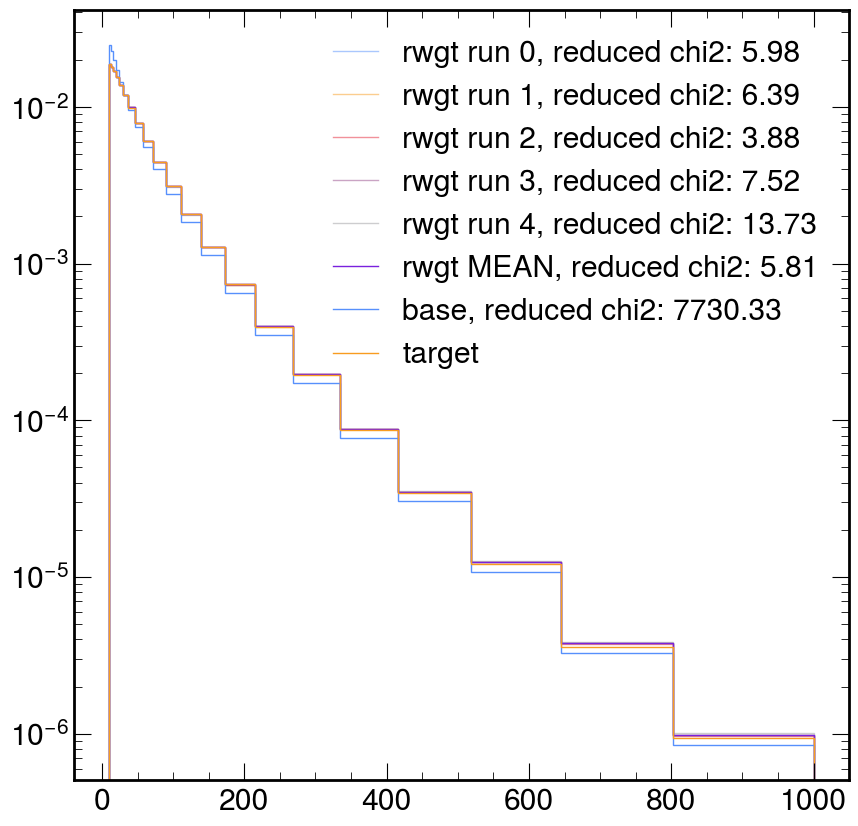

starting with batch_mult = 32 and mse loss
(7, 3, 21)


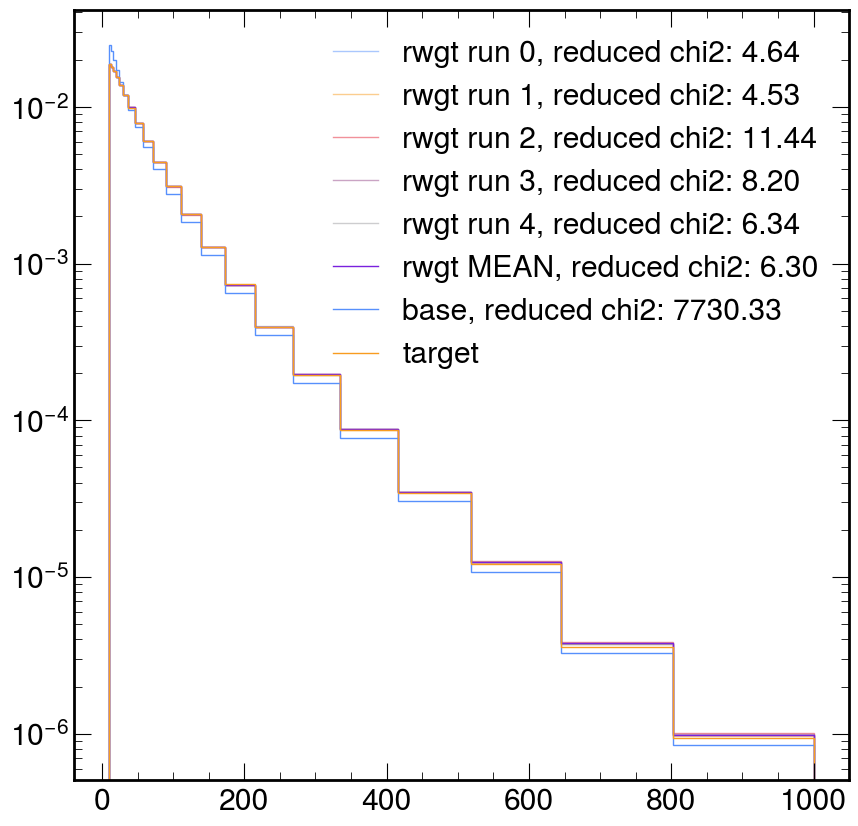

starting with batch_mult = 64 and mse loss
(7, 3, 21)


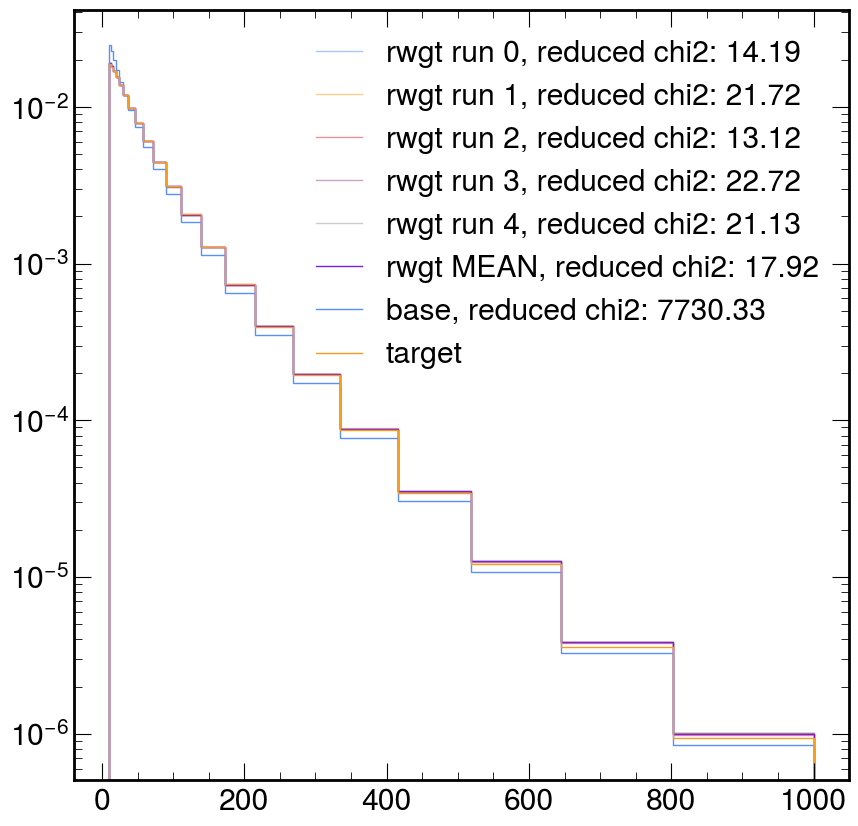

starting with batch_mult = 4 and cce loss
(7, 3, 21)


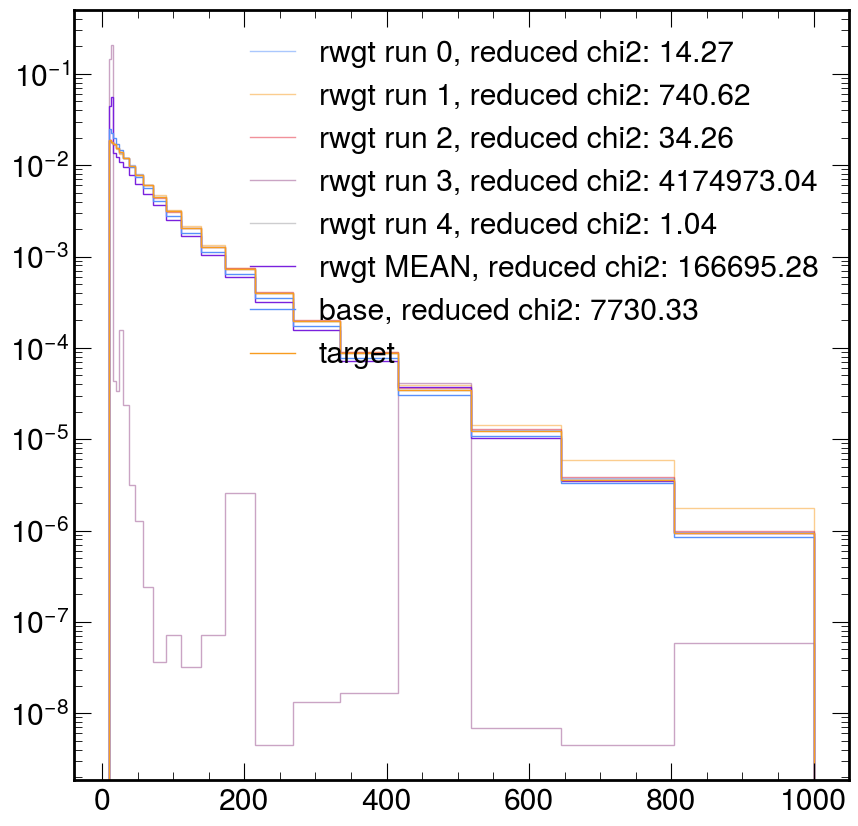

starting with batch_mult = 8 and cce loss
(7, 3, 21)


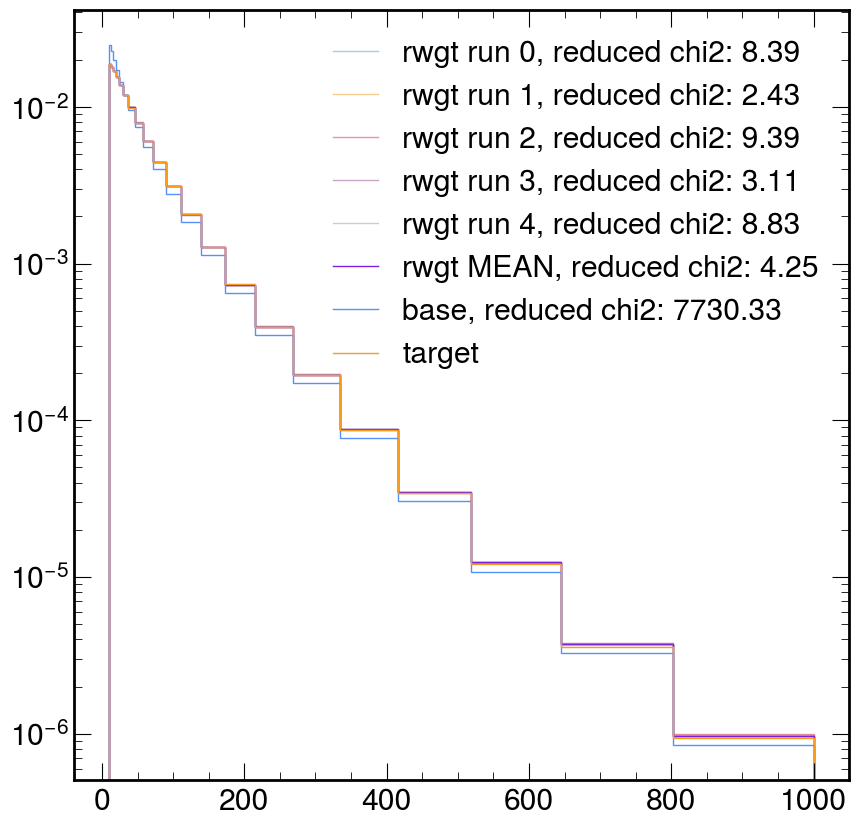

starting with batch_mult = 16 and cce loss
(7, 3, 21)


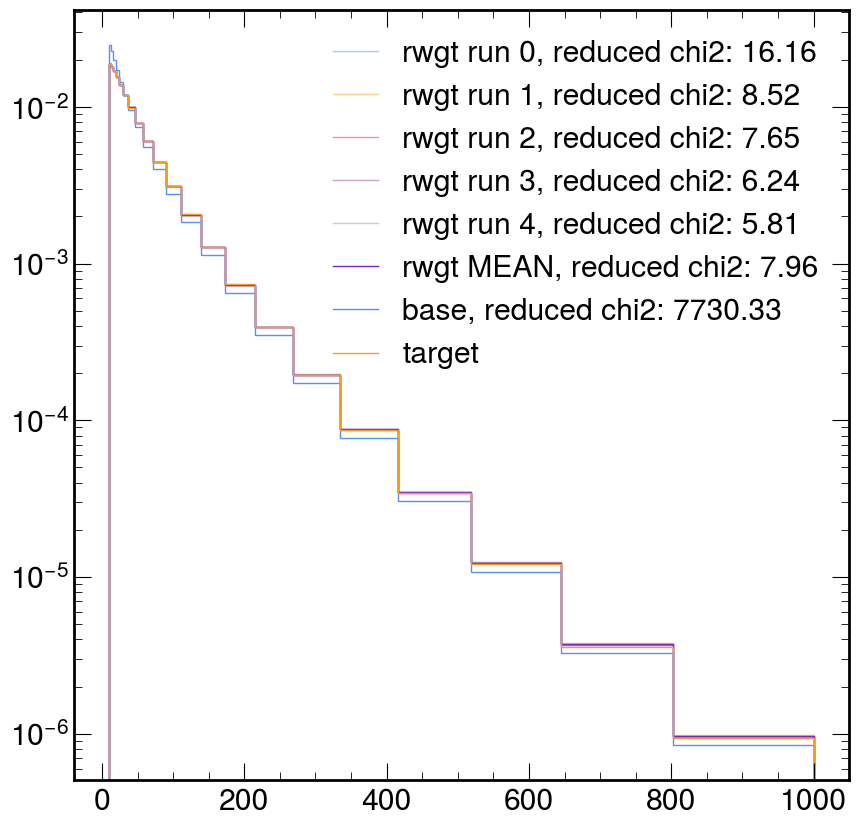

starting with batch_mult = 32 and cce loss
(7, 3, 21)


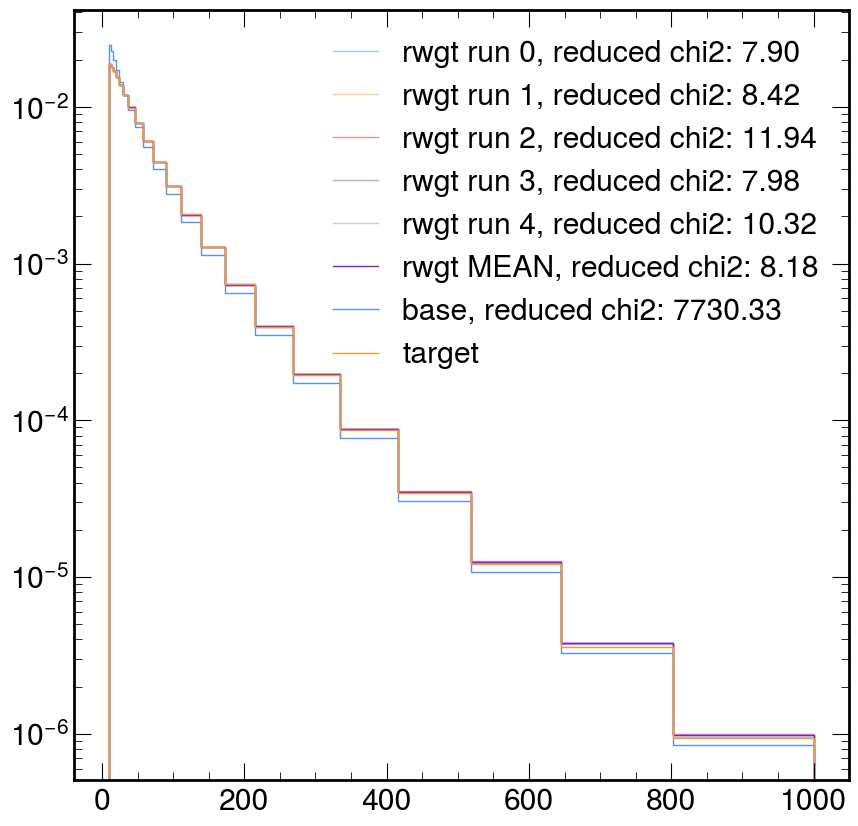

starting with batch_mult = 64 and cce loss
(7, 3, 21)


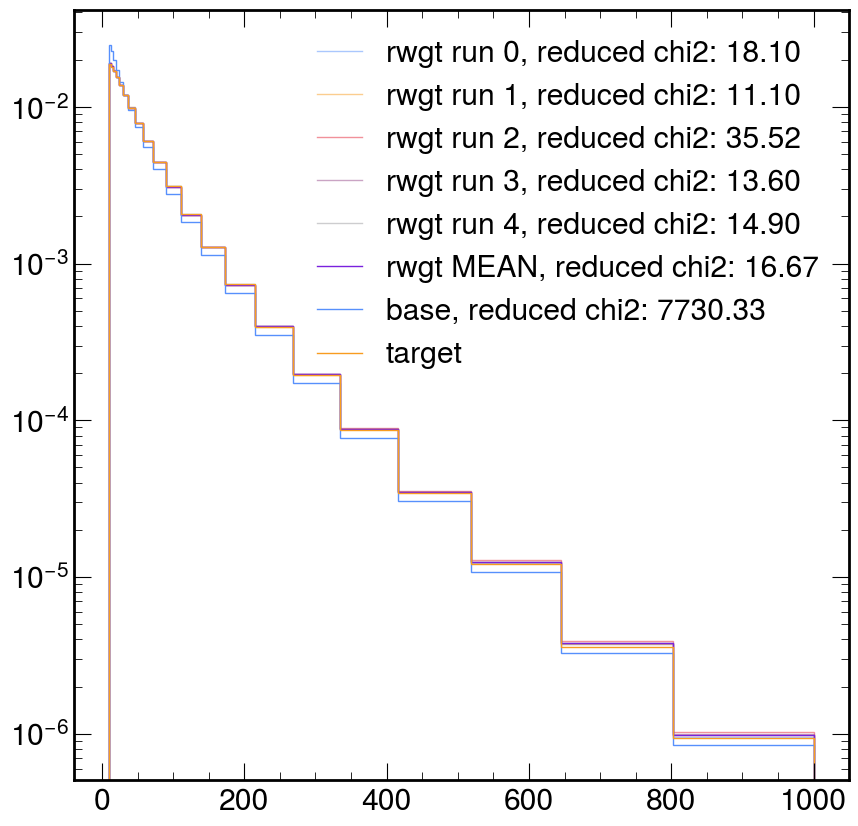

In [15]:
N = len(x1_plt)

for loss in losses:
    for batch_mult in batch_sizes:
        print(f'starting with {batch_mult = } and {loss} loss')
        
        batch_size = batch_mult*8192

        label = f'DCTR_NNLO_{loss}_pos_rwgt_batchsize_{batch_size}_hists'
        batch_hists = np.load(f'{save_path}{label}.npy')
        print(batch_hists.shape)

        # pt
        fig, ax = plt.subplots()
        for i in range(0, runs):
            pt_hist = batch_hists[i][0]
            reduced_chi2 = reduced_chi2_test(pt_hist, pt_hist_target, pt_bins, N)
            ax.stairs(pt_hist, pt_bins, label=f'rwgt run {i}, reduced chi2: {reduced_chi2:.2f}', alpha = 0.5)

        pt_hist_mean = batch_hists[-2][0] # last two are mean and std
        # pt_hist_std  = batch_hists[-1][0]
        reduced_chi2 = reduced_chi2_test(pt_hist_mean, pt_hist_target, pt_bins, N)
        ax.stairs(pt_hist_mean, pt_bins, label=f'rwgt MEAN, reduced chi2: {reduced_chi2:.2f}')

        reduced_chi2 = reduced_chi2_test(pt_hist_base, pt_hist_target, pt_bins, N)
        ax.stairs(pt_hist_base, pt_bins, label=f'base, reduced chi2: {reduced_chi2:.2f}')
        ax.stairs(pt_hist_target, pt_bins, label=f'target')
        plt.legend()
        plt.yscale('log')
        plt.show()


starting with batch_mult = 4 and mse loss
(7, 3, 21)


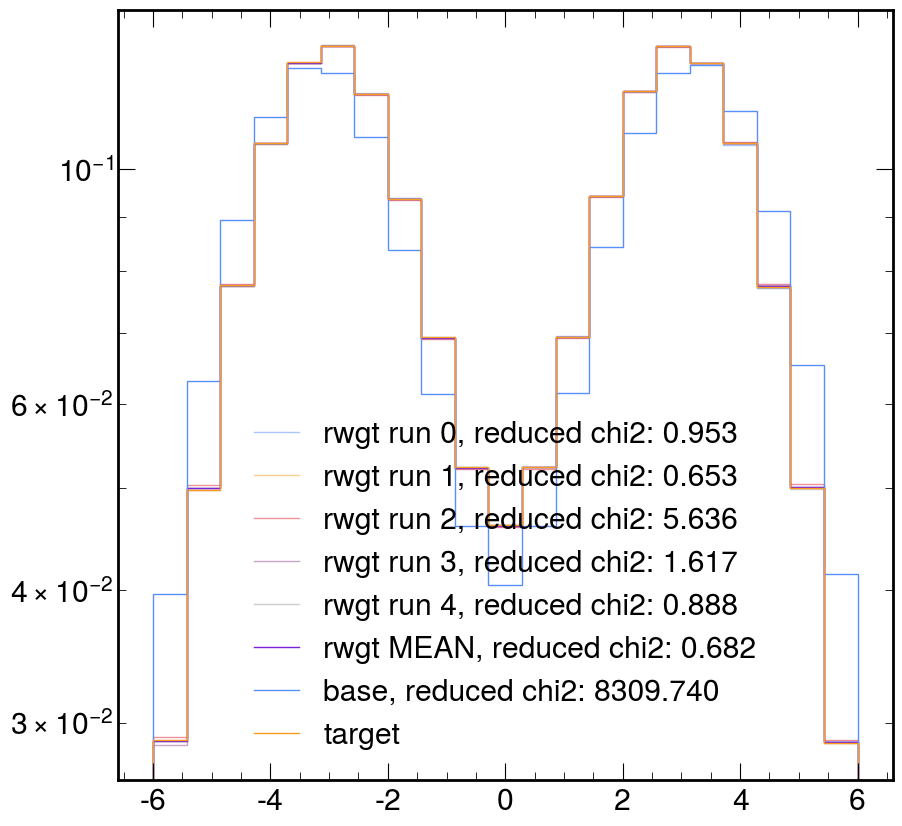

starting with batch_mult = 8 and mse loss
(7, 3, 21)


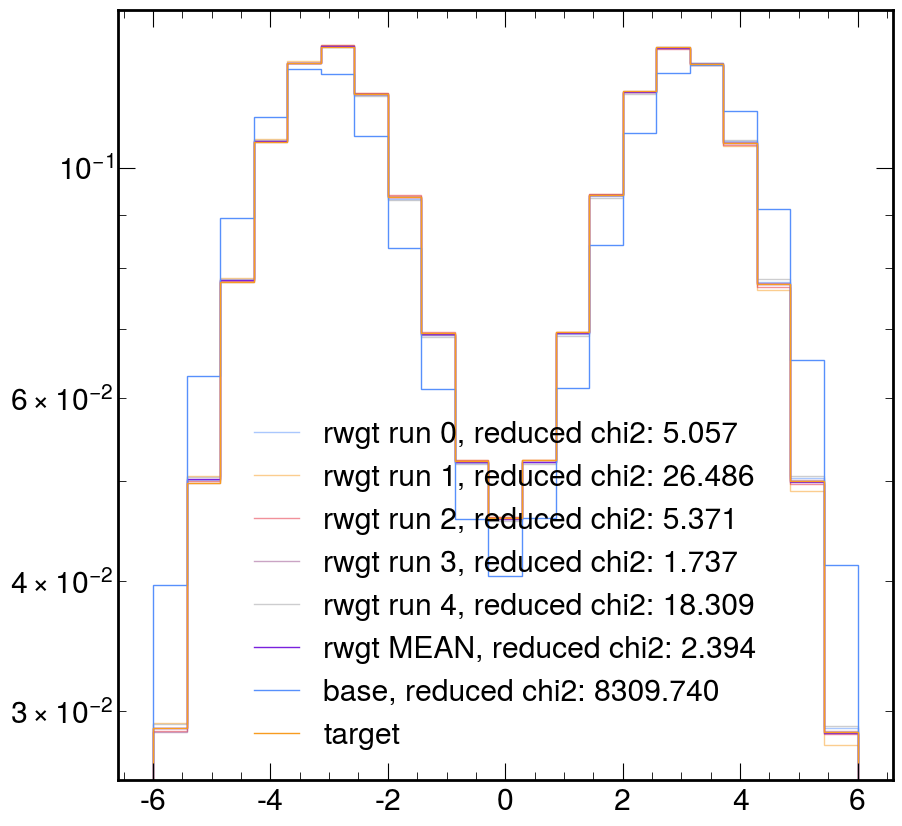

starting with batch_mult = 16 and mse loss
(7, 3, 21)


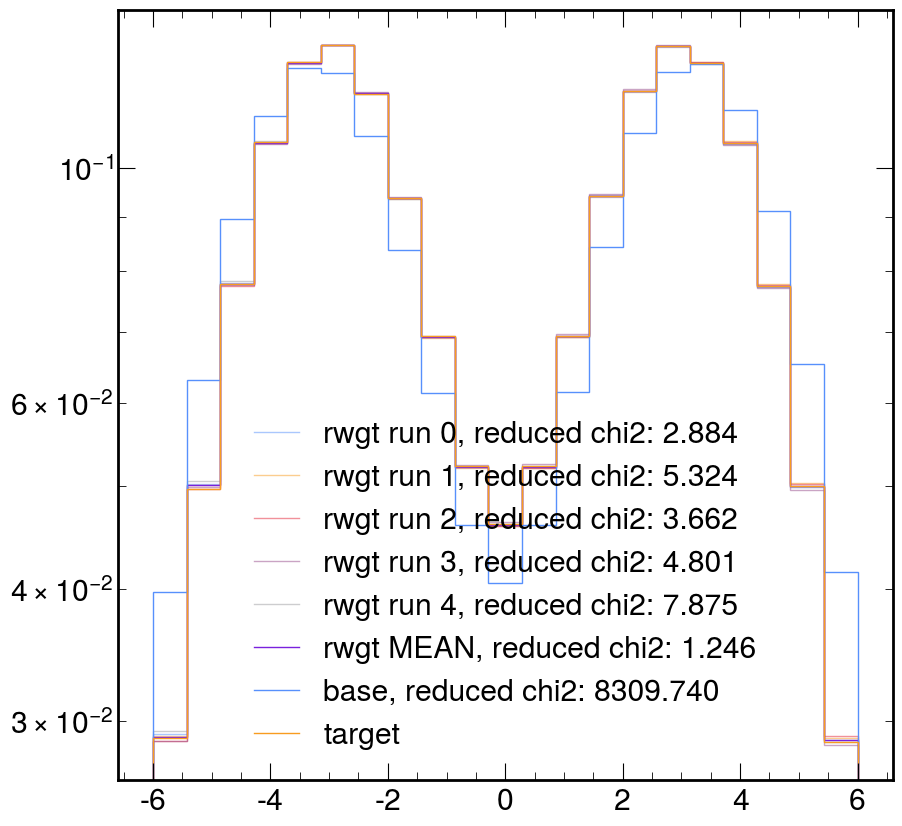

starting with batch_mult = 32 and mse loss
(7, 3, 21)


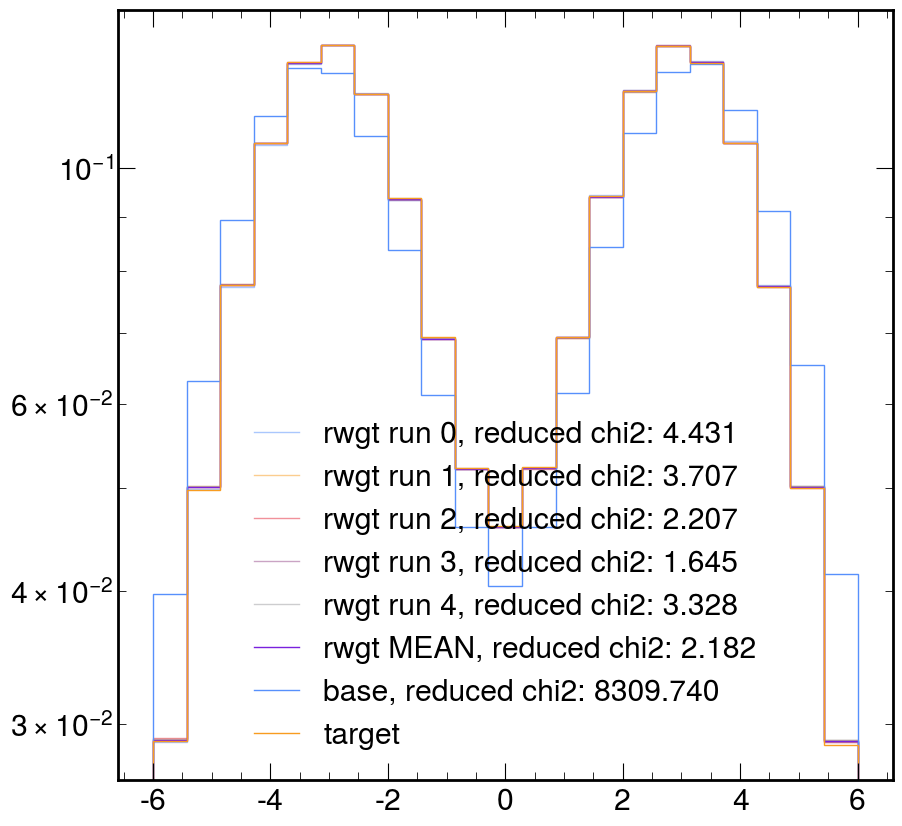

starting with batch_mult = 64 and mse loss
(7, 3, 21)


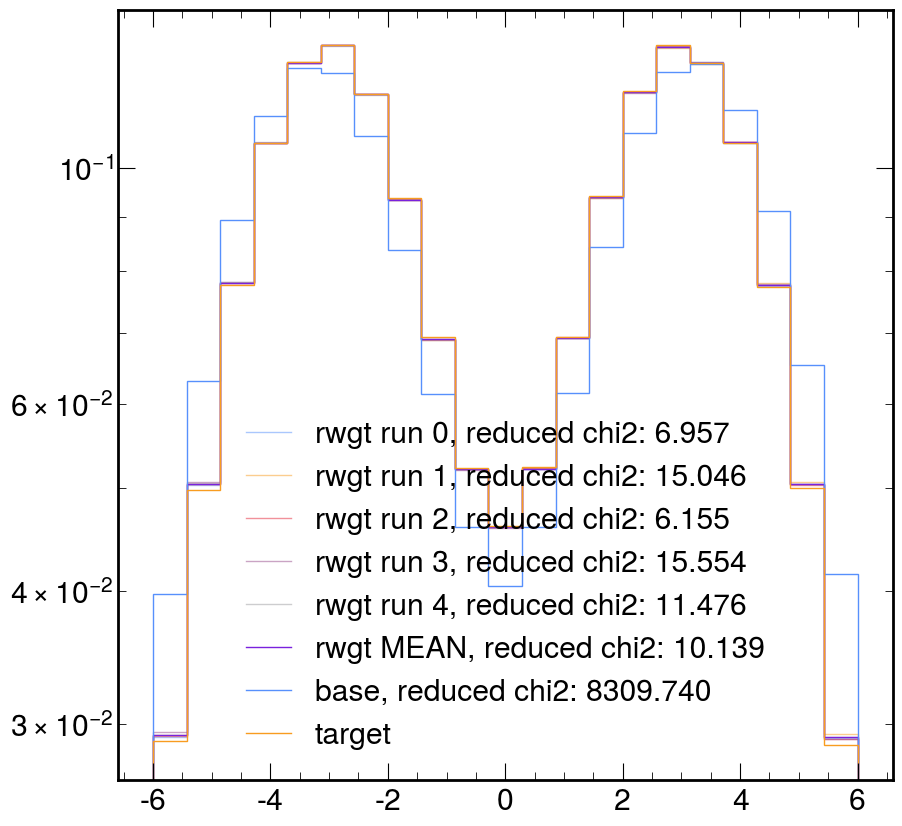

starting with batch_mult = 4 and cce loss
(7, 3, 21)


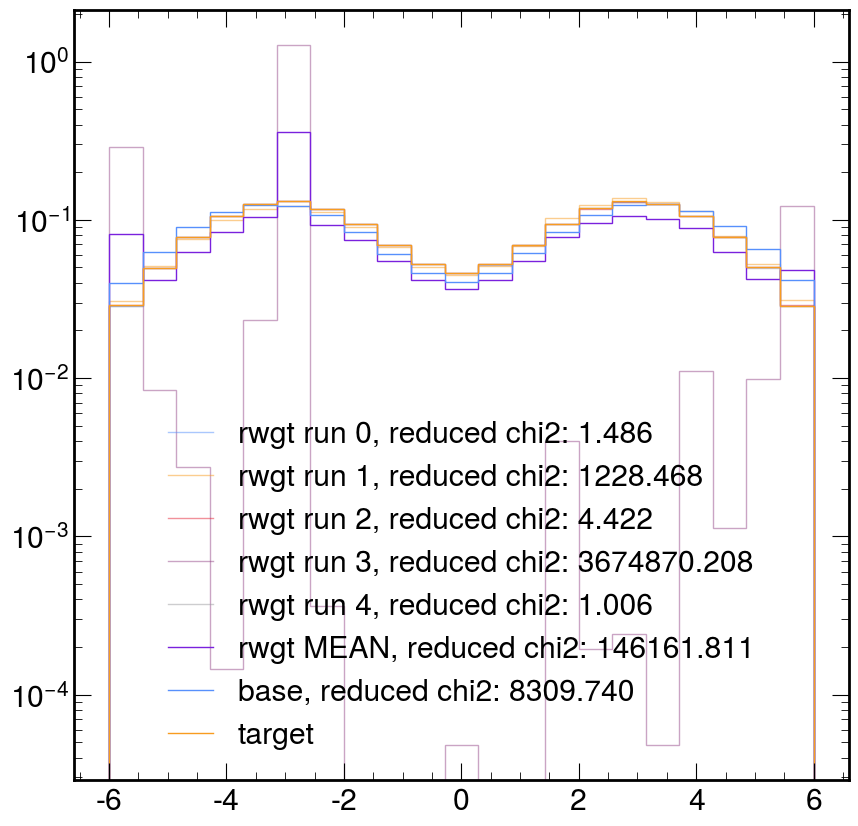

starting with batch_mult = 8 and cce loss
(7, 3, 21)


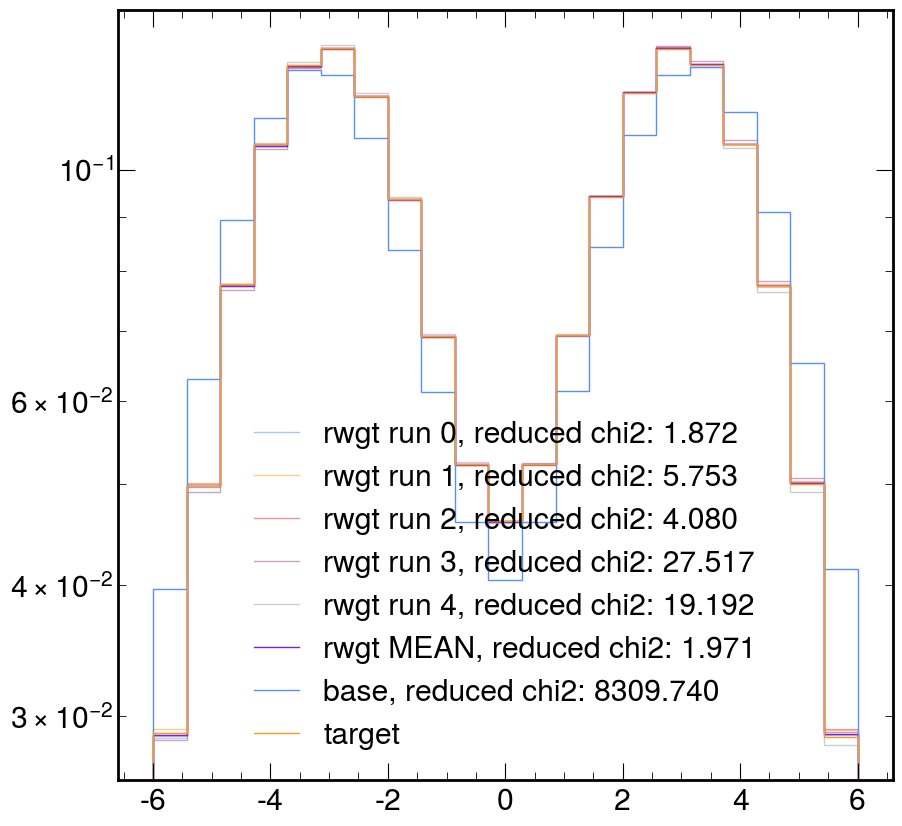

starting with batch_mult = 16 and cce loss
(7, 3, 21)


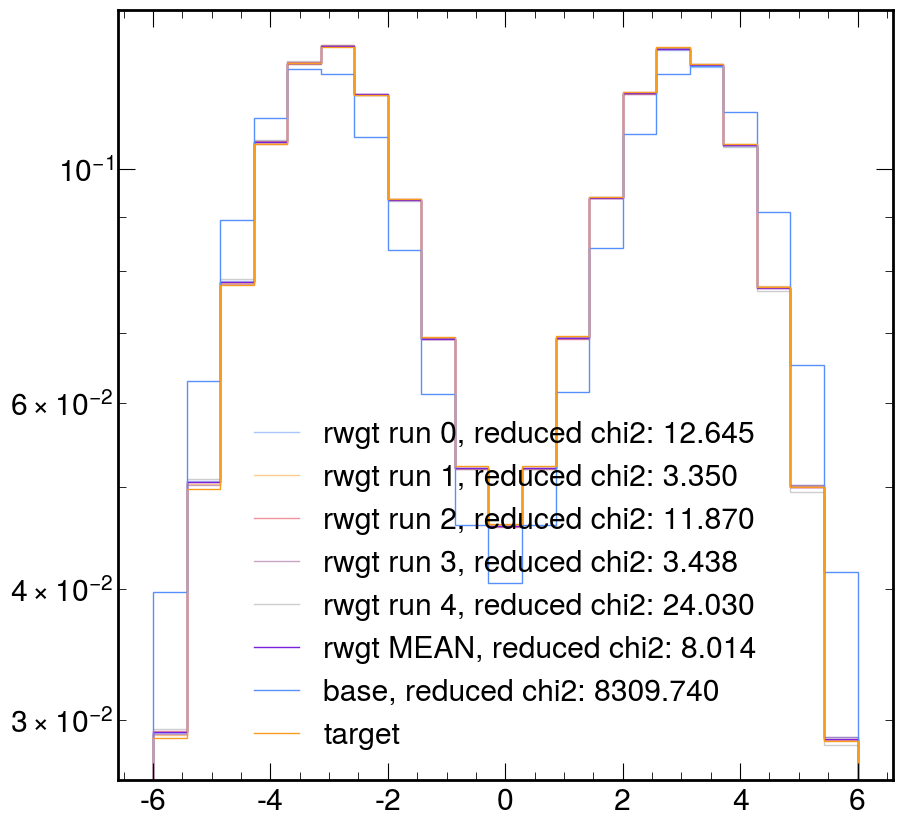

starting with batch_mult = 32 and cce loss
(7, 3, 21)


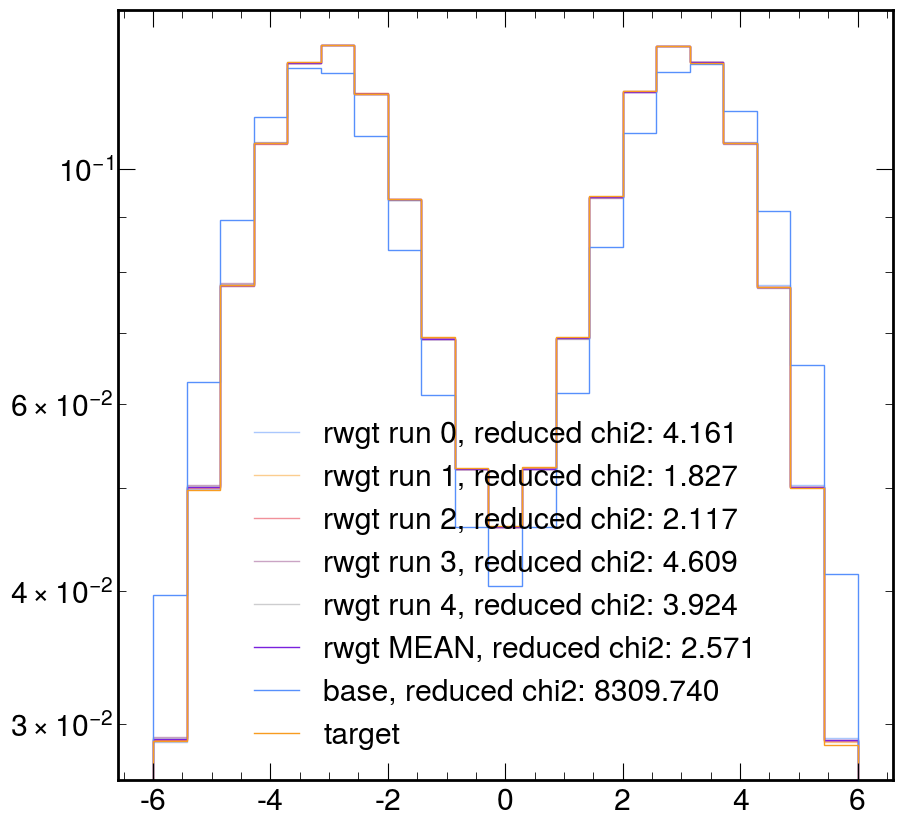

starting with batch_mult = 64 and cce loss
(7, 3, 21)


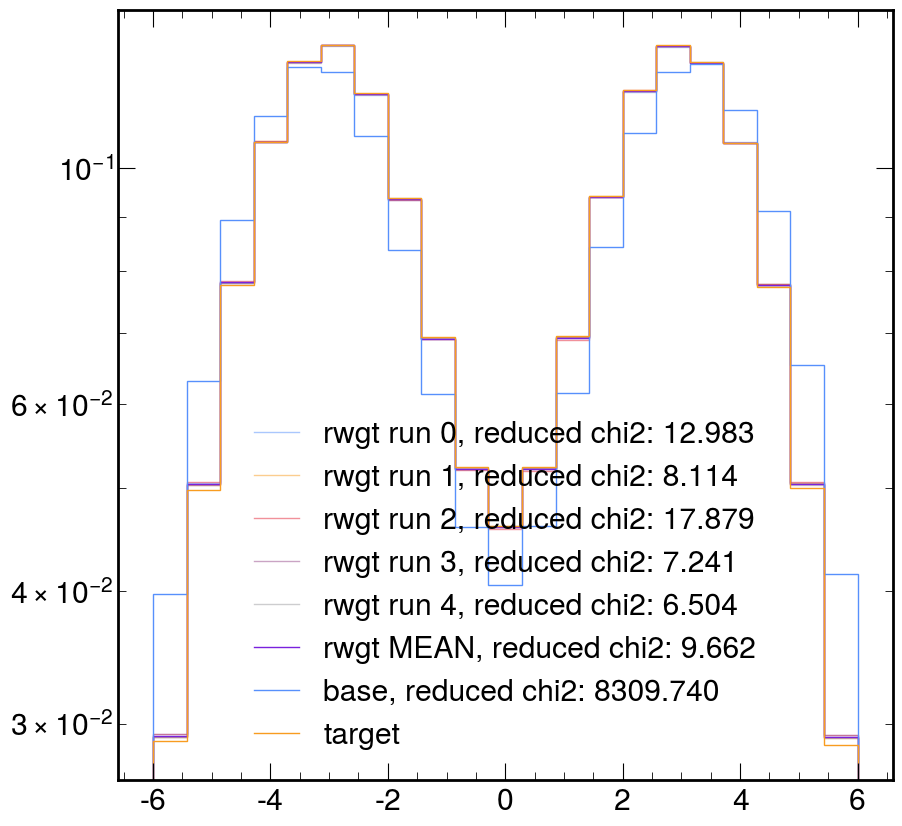

In [13]:
N = len(x1_plt)

for loss in losses:
    for batch_mult in batch_sizes:
        print(f'starting with {batch_mult = } and {loss} loss')
        
        batch_size = batch_mult*8192

        label = f'DCTR_NNLO_{loss}_pos_rwgt_batchsize_{batch_size}_hists'
        batch_hists = np.load(f'{save_path}{label}.npy')
        print(batch_hists.shape)


        # eta
        fig, ax = plt.subplots()
        for i in range(0, runs):
            eta_hist = batch_hists[i][1]
            reduced_chi2 = reduced_chi2_test(eta_hist, eta_hist_target, eta_bins, N)
            ax.stairs(eta_hist, eta_bins, label=f'rwgt run {i}, reduced chi2: {reduced_chi2:.3f}', alpha = 0.5)
        
        eta_hist_mean = batch_hists[-2][1] # last two are mean and std
        # eta_hist_std  = batch_hists[-1][1]
        reduced_chi2 = reduced_chi2_test(eta_hist_mean, eta_hist_target, eta_bins, N)
        ax.stairs(eta_hist_mean, eta_bins, label=f'rwgt MEAN, reduced chi2: {reduced_chi2:.3f}')

        reduced_chi2 = reduced_chi2_test(eta_hist_base, eta_hist_target, eta_bins, N)
        ax.stairs(eta_hist_base, eta_bins, label=f'base, reduced chi2: {reduced_chi2:.3f}')
        ax.stairs(eta_hist_target, eta_bins, label=f'target')
        plt.legend()
        plt.yscale('log')
        plt.show()


starting with batch_mult = 4 and mse loss
(7, 3, 21)


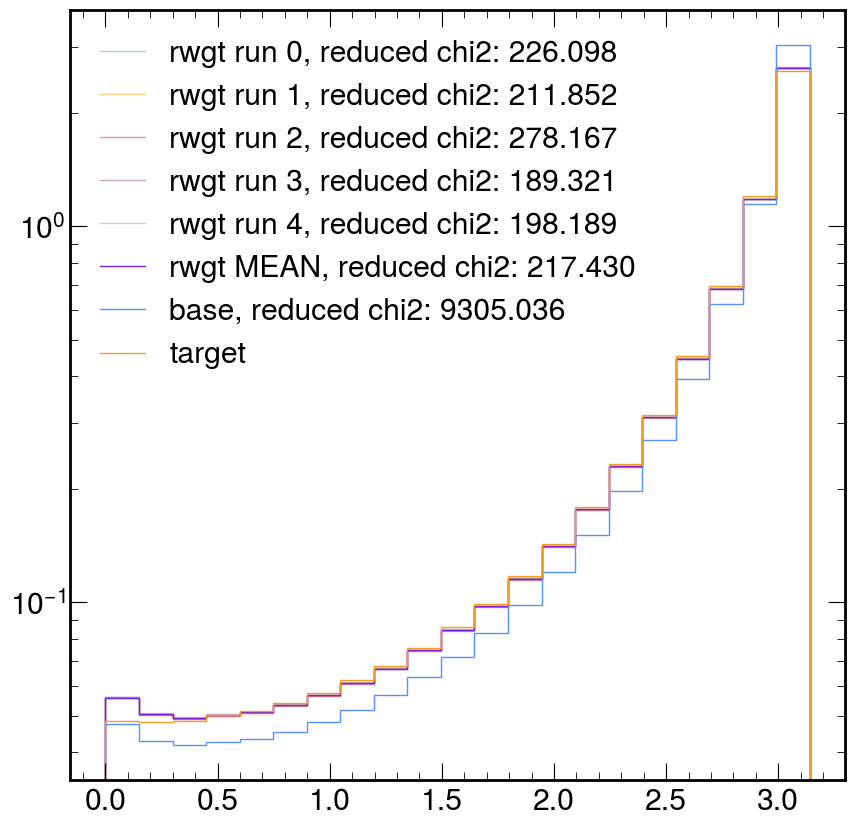

starting with batch_mult = 8 and mse loss
(7, 3, 21)


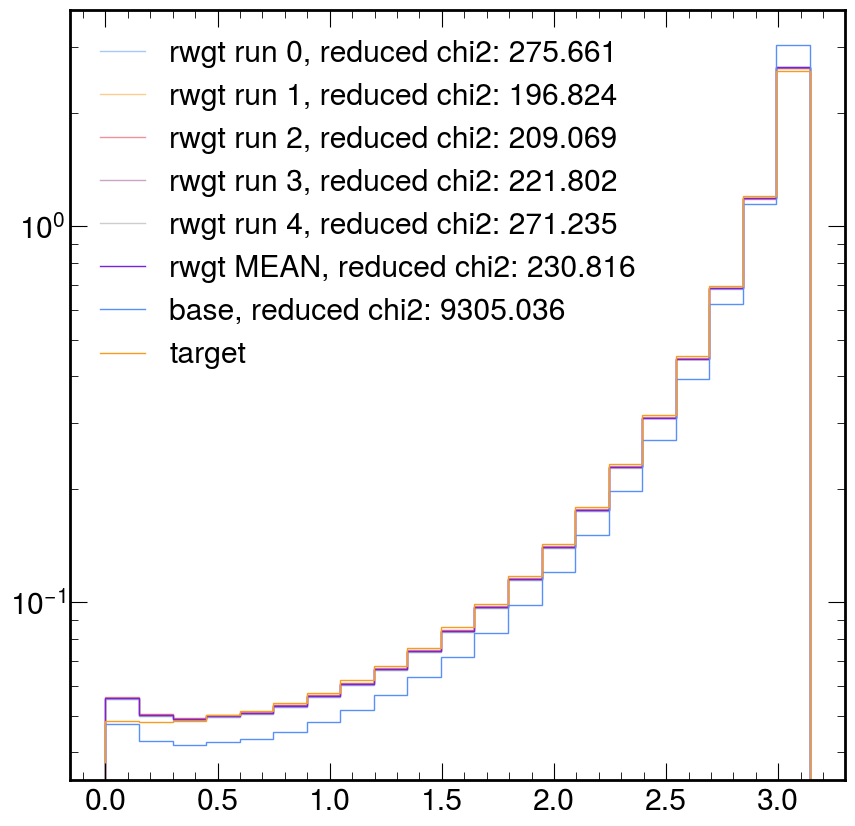

starting with batch_mult = 16 and mse loss
(7, 3, 21)


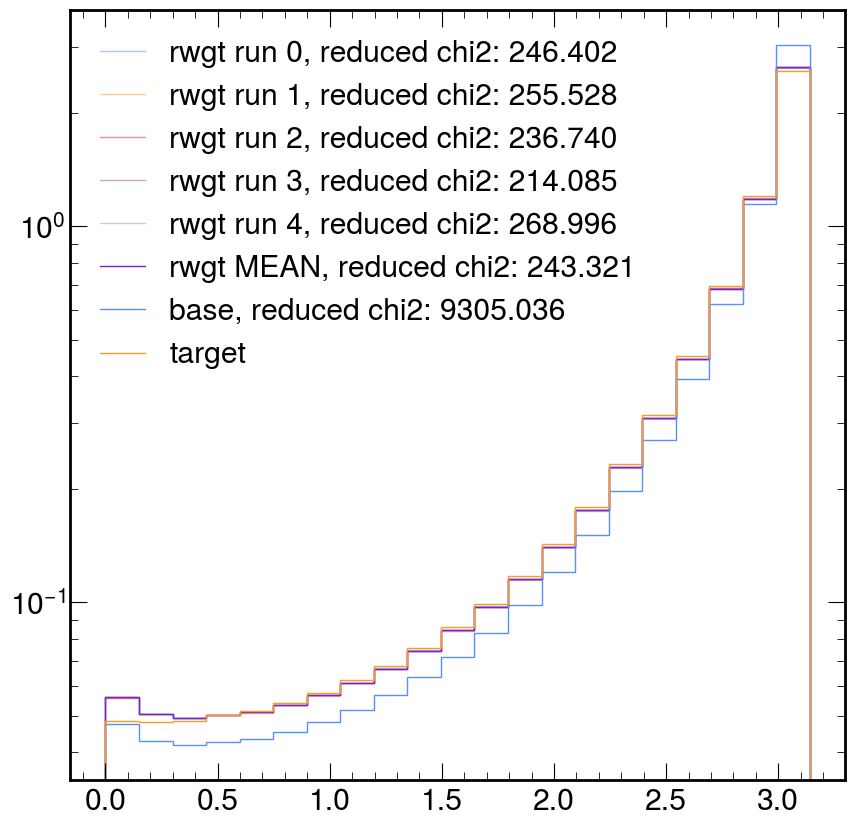

starting with batch_mult = 32 and mse loss
(7, 3, 21)


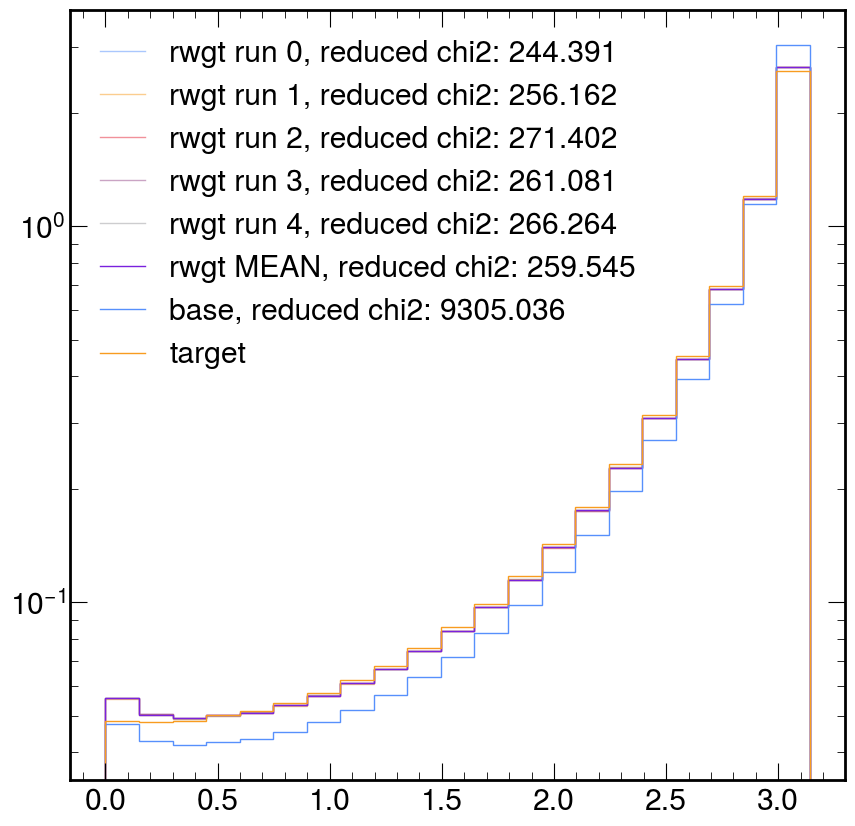

starting with batch_mult = 64 and mse loss
(7, 3, 21)


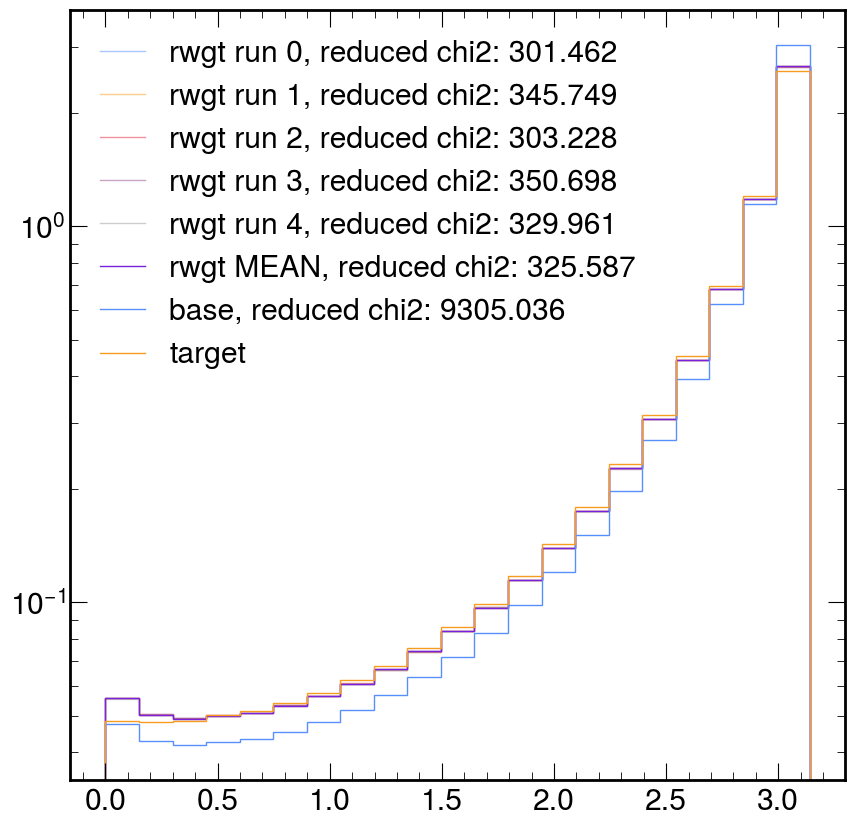

starting with batch_mult = 4 and cce loss
(7, 3, 21)


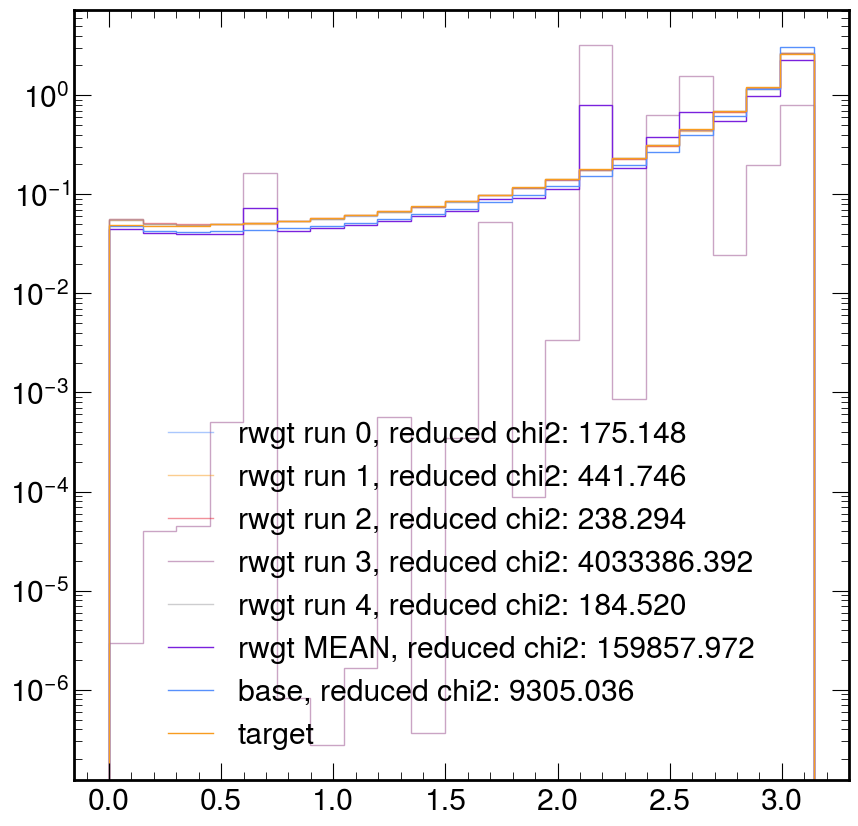

starting with batch_mult = 8 and cce loss
(7, 3, 21)


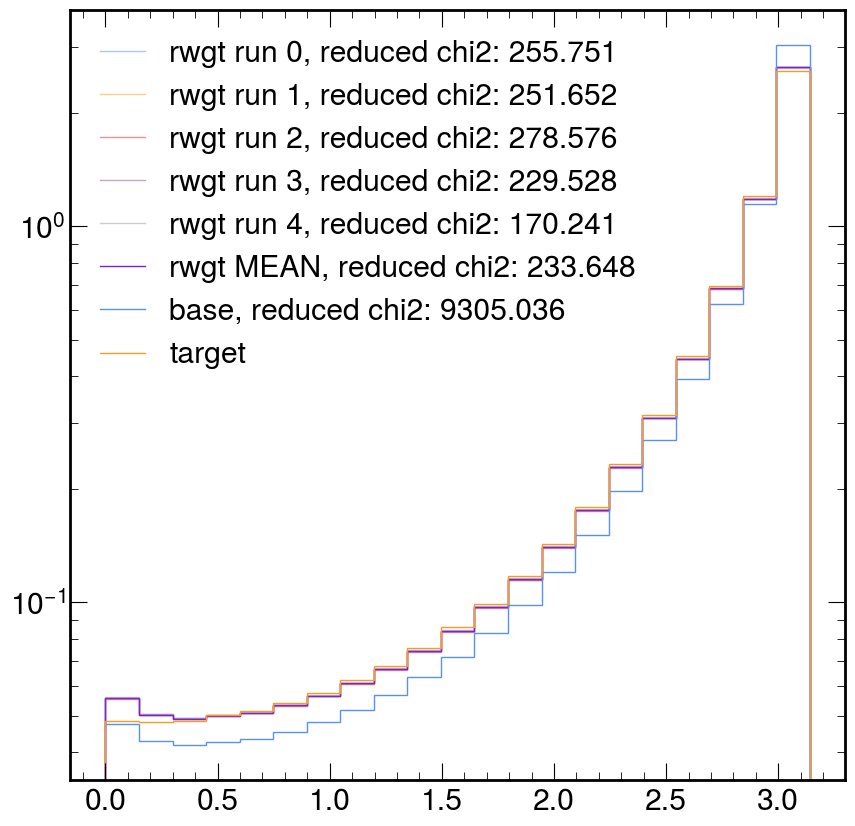

starting with batch_mult = 16 and cce loss
(7, 3, 21)


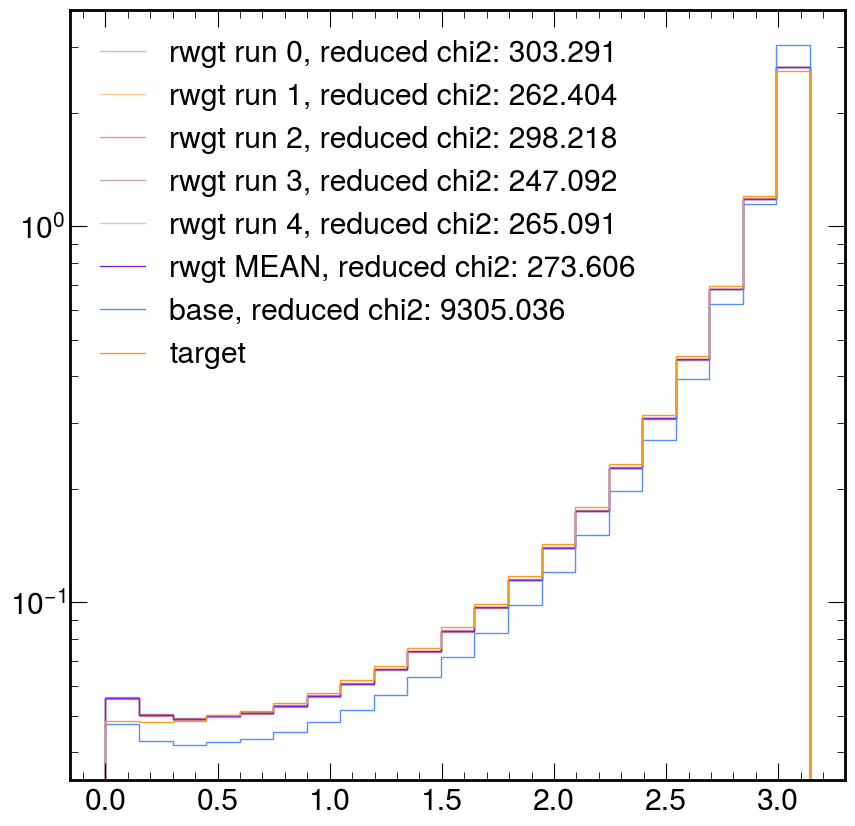

starting with batch_mult = 32 and cce loss
(7, 3, 21)


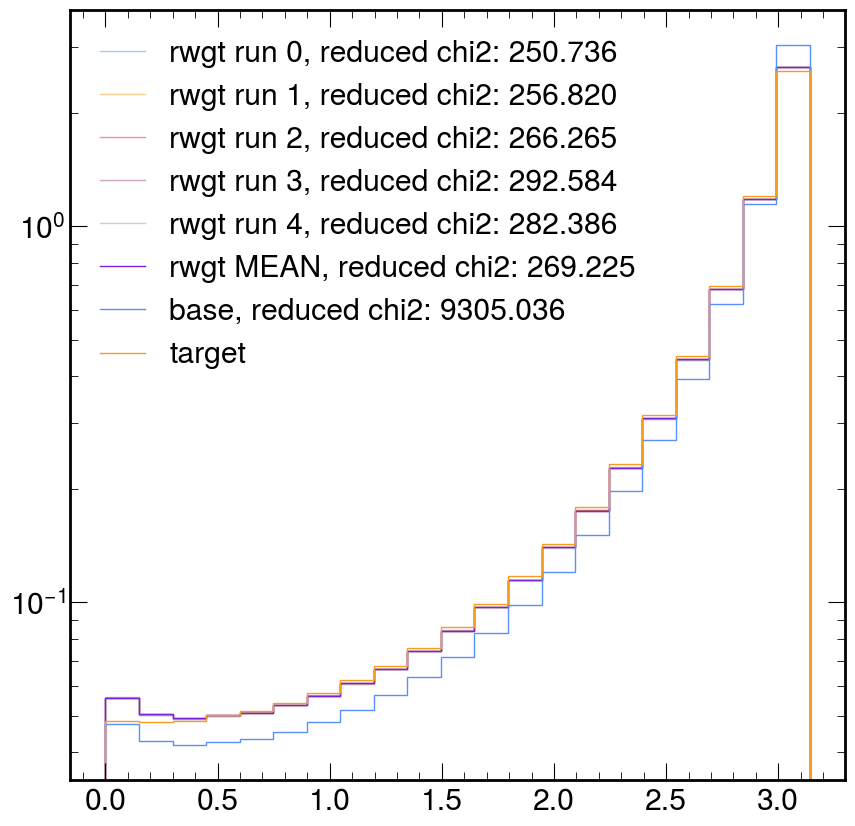

starting with batch_mult = 64 and cce loss
(7, 3, 21)


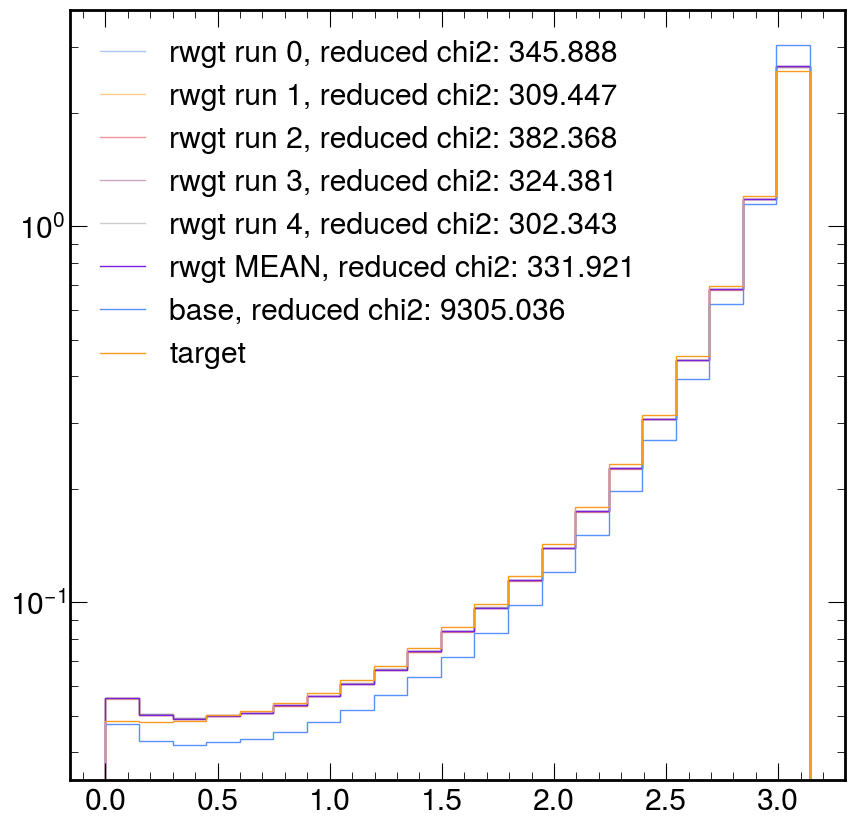

In [14]:
N = len(x1_plt)

for loss in losses:
    for batch_mult in batch_sizes:
        print(f'starting with {batch_mult = } and {loss} loss')
        
        batch_size = batch_mult*8192

        label = f'DCTR_NNLO_{loss}_pos_rwgt_batchsize_{batch_size}_hists'
        batch_hists = np.load(f'{save_path}{label}.npy')
        print(batch_hists.shape)

        # delta phi
        fig, ax = plt.subplots()
        for i in range(0, runs):
            phi_hist = batch_hists[i][2]
            reduced_chi2 = reduced_chi2_test(phi_hist, phi_hist_target, phi_bins, N)
            ax.stairs(phi_hist, phi_bins, label=f'rwgt run {i}, reduced chi2: {reduced_chi2:.3f}', alpha = 0.5)
        
        phi_hist_mean = batch_hists[-2][2] # last two are mean and std
        # phi_hist_std  = batch_hists[-1][2]
        reduced_chi2 = reduced_chi2_test(phi_hist_mean, phi_hist_target, phi_bins, N)
        ax.stairs(phi_hist_mean, phi_bins, label=f'rwgt MEAN, reduced chi2: {reduced_chi2:.3f}')

        reduced_chi2 = reduced_chi2_test(phi_hist_base, phi_hist_target, phi_bins, N)
        ax.stairs(phi_hist_base, phi_bins, label=f'base, reduced chi2: {reduced_chi2:.3f}')
        ax.stairs(phi_hist_target, phi_bins, label=f'target')
        plt.legend()
        plt.yscale('log')
        plt.show()
        

In [20]:
import itertools

runs = 5
losses = ['mse', 'cce']
batch_sizes = [1, 2, 4, 8, 16] # mulipliers of 8192
wgts = ['org', 'np_mse', 'np_cce']

total_runs = 2 * len(wgts) * runs * len(batch_sizes) # *2 b/c testing mse and cce
#          = 150 with default num runs, wgts, and batch_sizes

combinations = list(itertools.product(losses, batch_sizes, wgts))

for process_id in range(1, 31):
    print(combinations[process_id - 1])




('mse', 1, 'org')
('mse', 1, 'np_mse')
('mse', 1, 'np_cce')
('mse', 2, 'org')
('mse', 2, 'np_mse')
('mse', 2, 'np_cce')
('mse', 4, 'org')
('mse', 4, 'np_mse')
('mse', 4, 'np_cce')
('mse', 8, 'org')
('mse', 8, 'np_mse')
('mse', 8, 'np_cce')
('mse', 16, 'org')
('mse', 16, 'np_mse')
('mse', 16, 'np_cce')
('cce', 1, 'org')
('cce', 1, 'np_mse')
('cce', 1, 'np_cce')
('cce', 2, 'org')
('cce', 2, 'np_mse')
('cce', 2, 'np_cce')
('cce', 4, 'org')
('cce', 4, 'np_mse')
('cce', 4, 'np_cce')
('cce', 8, 'org')
('cce', 8, 'np_mse')
('cce', 8, 'np_cce')
('cce', 16, 'org')
('cce', 16, 'np_mse')
('cce', 16, 'np_cce')
